In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
from matplotlib import pyplot as plt
import urllib.parse

### 1. Separate data into training, validation and test sets

In [9]:
data = pd.read_json('data/articles_and_labels.json.bz2', compression='bz2')
shape_before = data.shape
print(shape_before)
# Make sure all images have '/commons/' in their path, otherwise they apparently aren't in the WIT_Dataset
data = data[data.image_url.str.contains('/commons/')]
print(f'Images without /commons/ on their path that were removed: {shape_before[0] - data.shape[0]}')

# After /commons/ comes the file location as it is organized in the WIT_dataset, so take it:
data['image_paths'] = [url.split('commons/')[1] for url in data.image_url]

# Decode filename paths so they are validated by tensorflow later
data['image_paths'] = data['image_paths'].apply(lambda encoded_filename : urllib.parse.unquote(encoded_filename))

# Get test dataframe out of data:
test_indices = np.random.choice(size=(int(0.1 * len(data.index)), ), replace=False, a=data.index)
test_data = data.loc[test_indices, :]
print(f'Test data: {test_data.shape}')

# Remove test indices from train and validation dataframe
train_val_data = data.drop(labels=pd.Series(test_indices), axis=0)
print(f'Train data: {train_val_data.shape}')

(898358, 4)
Images without /commons/ on their path that were removed: 3026
Test data: (89533, 5)
Train data: (805799, 5)


In [12]:
train_val_data.head()

,image_url,page_url,page_title,taxo_labels,image_paths
0,https://upload.wikimedia.org/wikipedia/commons...,https://en.wikipedia.org/wiki/Oxydactylus,Oxydactylus,"[STEM.Biology, STEM.STEM*, STEM.Earth and envi...",5/5f/Oxydactylus_longipes_fm.jpg
1,https://upload.wikimedia.org/wikipedia/commons...,https://en.wikipedia.org/wiki/Maine%27s_3rd_co...,Maine's 3rd congressional district,"[History and Society.Politics and government, ...",7/7d/SamuelWGould.jpg
3,https://upload.wikimedia.org/wikipedia/commons...,https://en.wikipedia.org/wiki/Akseli_Gallen-Ka...,Akseli Gallen-Kallela,"[Culture.Biography.Biography*, Geography.Regio...",f/fe/Akseli_Gallen-Kallela_Februari_fantasi.jpg
4,https://upload.wikimedia.org/wikipedia/commons...,https://da.wikipedia.org/wiki/Akseli_Gallen-Ka...,Akseli Gallen-Kallela,"[Culture.Biography.Biography*, Geography.Regio...",e/ea/Gallen-Kallela_Joukahainen's_revenge.jpg
5,https://upload.wikimedia.org/wikipedia/commons...,https://en.wikipedia.org/wiki/Akseli_Gallen-Ka...,Akseli Gallen-Kallela,"[Culture.Biography.Biography*, Geography.Regio...",c/ce/Sigurd_Wettenhovi-Aspa_-_Akseli_Gallen-Ka...


Divide dataset into train and validation sets

In [19]:
from keras.preprocessing.image import ImageDataGenerator

IMAGE_DIMENSION = 64

# Data generator for training and validation sets, performs data augmentations
train_val_generator = ImageDataGenerator(validation_split=0.10, 
                                         rescale=1/255, # rescale inputs so that they are between 0 and 1, and not 0 and 255
                                         rotation_range=40,
                                         width_shift_range=0.2,
                                         height_shift_range=0.2,
                                         shear_range=0.2,
                                         zoom_range=0.2,
                                         horizontal_flip=True,
                                         fill_mode='nearest') 
train = train_val_generator.flow_from_dataframe(dataframe=train_val_data, 
                                                directory='/scratch/WIT_Dataset/images', 
                                                x_col='image_paths', 
                                                y_col='taxo_labels', 
                                                class_mode='categorical',
                                                subset='training',
                                                validate_filenames=True,
                                                target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION)) # the dimensions to which all images found will be resized.
                                            
val = train_val_generator.flow_from_dataframe(dataframe=train_val_data, 
                                              directory='/scratch/WIT_Dataset/images', 
                                              x_col='image_paths', 
                                              y_col='taxo_labels', 
                                              class_mode='categorical',
                                              subset='validation',
                                              validate_filenames=False,
                                              target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION))

# Data generator for test set
test_generator = ImageDataGenerator(rescale=1/255) 
test = test_generator.flow_from_dataframe(dataframe=test_data,
                                          directory='/scratch/WIT_Dataset/images',
                                          x_col='image_paths', 
                                          y_col='taxo_labels', 
                                          class_mode='categorical',
                                          validate_filenames=True,
                                          target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION))

/home/matvieir/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 126492 invalid image filename(s) in x_col="image_paths". These filename(s) will be ignored.
  warnings.warn(


Found 611377 validated image filenames belonging to 64 classes.
Found 80579 non-validated image filenames belonging to 64 classes.


/home/matvieir/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 14085 invalid image filename(s) in x_col="image_paths". These filename(s) will be ignored.
  warnings.warn(


Found 75448 validated image filenames belonging to 64 classes.


### 2. Construct and train model
Here, we construct a model where the first layers are EfficientNetB0 pre-trained on ImageNet-1k(https://keras.io/api/applications/efficientnet/) with added layers to the end, and train these final end layers with our training data.

In [15]:
from tensorflow.keras.applications import EfficientNetB0
from keras.models import Sequential
from keras.layers import Dense, Flatten

# Take efficientnet pre-trained on imagenet-1k, not including the last layer 
N_CLASSES = 64
efficient_net = EfficientNetB0(include_top=False, 
                               weights='imagenet', 
                               input_shape=(IMAGE_DIMENSION, IMAGE_DIMENSION, 3), # to be specified if include_top is False.
                               classes=N_CLASSES,
                               )
efficient_net.trainable = False

In [16]:
# Add a final layer with the same number of neurons as there are classes and train only weights of this layer, i.e. transfer learning!
model = Sequential()
model.add(efficient_net)
model.add(Flatten())
model.add(Dense(units=120, activation='relu'))
model.add(Dense(units=N_CLASSES, activation='sigmoid')) # output layer

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 2, 2, 1280)       4049571   
                                                                 
 flatten (Flatten)           (None, 5120)              0         
                                                                 
 dense (Dense)               (None, 120)               614520    
                                                                 
 dense_1 (Dense)             (None, 64)                7744      
                                                                 
Total params: 4,671,835
Trainable params: 622,264
Non-trainable params: 4,049,571
_________________________________________________________________


Compile model

In [17]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(lr=0.0001), 
              loss='binary_crossentropy', # on what loss function to choose: https://stats.stackexchange.com/questions/260505/should-i-use-a-categorical-cross-entropy-or-binary-cross-entropy-loss-for-binary
              metrics=['accuracy']
              ) 

/home/matvieir/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Train model

In [20]:
epochs = 50
history = model.fit(train, 
                    epochs=50, 
                    steps_per_epoch=15, 
                    validation_data=val,
                    validation_steps=7
                    )

Epoch 1/50
15/15 [==============================] - ETA: 0s - loss: 0.5714 - accuracy: 0.0396

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/WIT_Dataset/images/8/8a/Montferrand-du-Périgord_-_Halles_-1.JPG'

Plot training vs validation accuracy and loss

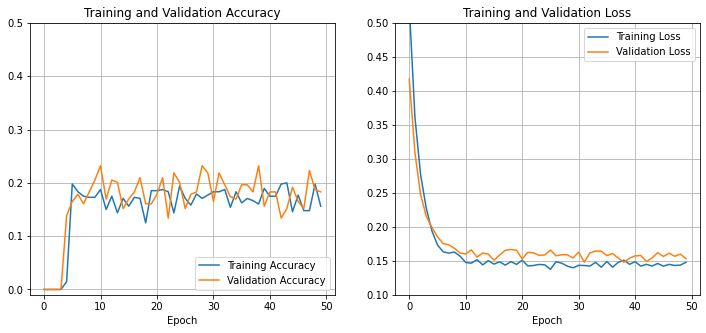

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.xlabel('Epoch')
plt.ylim(-0.01, 0.5)
plt.grid(True)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.xlabel('Epoch')
plt.ylim(0.1, 0.5)
plt.grid(True)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 3. Evaluation metrics
Here, we evaluate the trained model on the test set and take out classification metrics (precision & recall) for each of the individual 64 classes.

In [13]:
test_accuracy_score = model.evaluate(test)
print(test_accuracy_score)
print("Accuracy: {:.4f}%".format(test_accuracy_score[1] * 100)) 
print("Loss: ", test_accuracy_score[0])

In [14]:
predictions = model.predict(test)
print(predictions.shape)
threshold = 0.1
y_pred = 1 * (predictions > threshold)

InvalidArgumentError: Graph execution error:

ValueError: Decompressed Data Too Large
Traceback (most recent call last):

  File "/home/matvieir/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/home/matvieir/anaconda3/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/home/matvieir/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1004, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/matvieir/anaconda3/lib/python3.8/site-packages/keras/engine/data_adapter.py", line 830, in wrapped_generator
    for data in generator_fn():

  File "/home/matvieir/anaconda3/lib/python3.8/site-packages/keras/engine/data_adapter.py", line 956, in generator_fn
    yield x[i]

  File "/home/matvieir/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/iterator.py", line 65, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "/home/matvieir/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/iterator.py", line 227, in _get_batches_of_transformed_samples
    img = load_img(filepaths[j],

  File "/home/matvieir/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/utils.py", line 114, in load_img
    img = pil_image.open(io.BytesIO(f.read()))

  File "/home/matvieir/anaconda3/lib/python3.8/site-packages/PIL/Image.py", line 2953, in open
    im = _open_core(fp, filename, prefix, formats)

  File "/home/matvieir/anaconda3/lib/python3.8/site-packages/PIL/Image.py", line 2939, in _open_core
    im = factory(fp, filename)

  File "/home/matvieir/anaconda3/lib/python3.8/site-packages/PIL/ImageFile.py", line 121, in __init__
    self._open()

  File "/home/matvieir/anaconda3/lib/python3.8/site-packages/PIL/PngImagePlugin.py", line 694, in _open
    s = self.png.call(cid, pos, length)

  File "/home/matvieir/anaconda3/lib/python3.8/site-packages/PIL/PngImagePlugin.py", line 187, in call
    return getattr(self, "chunk_" + cid.decode("ascii"))(pos, length)

  File "/home/matvieir/anaconda3/lib/python3.8/site-packages/PIL/PngImagePlugin.py", line 397, in chunk_iCCP
    icc_profile = _safe_zlib_decompress(s[i + 2 :])

  File "/home/matvieir/anaconda3/lib/python3.8/site-packages/PIL/PngImagePlugin.py", line 133, in _safe_zlib_decompress
    raise ValueError("Decompressed Data Too Large")

ValueError: Decompressed Data Too Large


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_predict_function_26786]

In [ ]:
# Transform 'test.classes' to a one-hot encoded matrix, y_true
y_true = np.zeros(y_pred.shape)
for row_idx, row in enumerate(test.classes):
    for idx in row:
        y_true[row_idx, idx] = 1

Checking for data imbalance

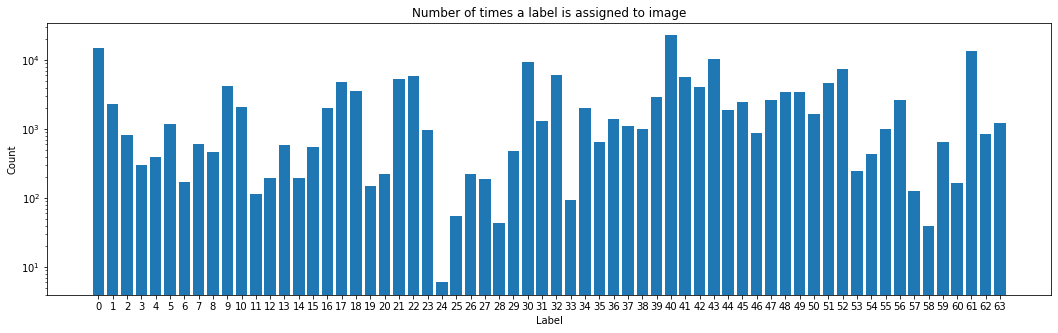

In [ ]:
from matplotlib import pyplot as plt 

_ = plt.figure(figsize=(18, 5))
_ = plt.title('Number of times a label is assigned to image')
_ = plt.xlabel('Label')
_ = plt.ylabel('Count')
_ = plt.yscale('log')
_ = plt.xticks(range(y_true.shape[1]), range(y_true.shape[1]), fontsize=10)
_ = plt.bar(test.class_indices.keys(), np.sum(y_true, axis=0))

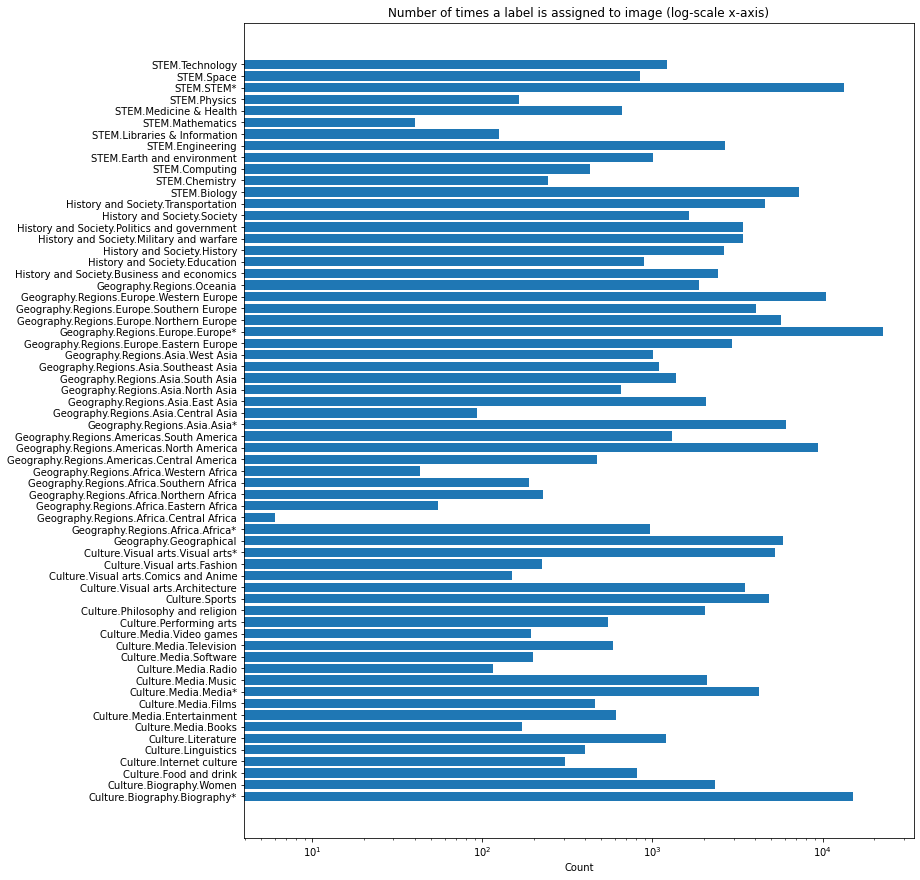

In [ ]:
_ = plt.figure(figsize=(12, 15))
_ = plt.title('Number of times a label is assigned to image (log-scale x-axis)')
_ = plt.barh(range(y_true.shape[1]), np.sum(y_true, axis=0))
_ = plt.yticks(range(y_true.shape[1]), list(test.class_indices.keys()))
_ = plt.xscale('log')
_ = plt.xlabel('Count')
_ = plt.grid(True)

Make predictions on the test set and then get classification metrics

In [ ]:
from sklearn.metrics import classification_report

metrics_df = pd.DataFrame(classification_report(y_true, y_pred, target_names=list(test.class_indices), output_dict=True)).transpose()
metrics_df['index'] = np.concatenate((np.arange(start=0, stop=N_CLASSES), [None, None, None, None]))
metrics_df.tail(4)

/home/matvieir/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/matvieir/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support,index
micro avg,0.216587,0.458550,0.294210,171172.0,None
macro avg,0.020305,0.093750,0.032696,171172.0,None
weighted avg,0.113939,0.458550,0.178722,171172.0,None
samples avg,0.216587,0.500748,0.289719,171172.0,None


Precision & recall metrics for each class

<ipython-input-18-a181c9d4aaec>:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(range(y_true.shape[1]), range(y_true.shape[1]))
<ipython-input-18-a181c9d4aaec>:11: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(range(y_true.shape[1]), range(y_true.shape[1]))


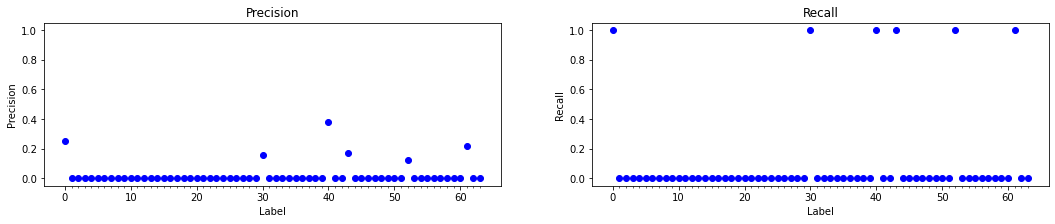

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(18,3))
axs[0].set_xlabel('Label')
axs[0].set_ylabel('Precision')
axs[0].set_title('Precision')
axs[1].set_xlabel('Label')
axs[1].set_ylabel('Recall')
axs[1].set_title('Recall')
axs[0].set_ylim([-0.05, 1.05])
axs[1].set_ylim([-0.05, 1.05])
axs[0].set_xticks(range(y_true.shape[1]), range(y_true.shape[1]))
axs[1].set_xticks(range(y_true.shape[1]), range(y_true.shape[1]))
axs[0].plot(range(y_true.shape[1]), metrics_df.precision[0:64], 'bo')
axs[1].plot(range(y_true.shape[1]), metrics_df.recall[0:64], 'bo')